<a href="https://colab.research.google.com/github/kayserena/machine-learning-datathon-6/blob/main/2_Clean_Final_Project_Logistic_Regression_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NOTE: The features used in this model were validated in the EDA + Neural Network codebook using the Variance Threshold feature selection method; as show in GitHub**

# 1.0 Loading Libraries and Data

In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import random
# !pip install missingno
import missingno as msno
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_excel('Diabetes Study File 10K Dec 14 2017.xlsx')
df.head()

,Age_at_Exam,sBP,sBP_Date,BMI,BMI_Date,LDL,LDL_Date,HDL,HDL_Date,A1c,...,leastO(A1c_Date),leastO(DM_OnsetDate),leastO(FBS_Date),LeastOfAll,A1C_BEF_DM,FBS_BEF_DM,Patient_ID,DM_Onset_Revised,DM_Onset_Revised_1YrPrior,DIABETES
0,65,126.0,2013-06-11,31.000000,2013-06-11,1.66,2013-06-14,1.11,2013-06-14,5.4,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000255903,NaT,NaT,No
1,62,135.0,2014-06-19,25.846483,2014-10-17,2.49,2014-05-28,1.37,2014-05-28,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000256456,NaT,NaT,No
2,63,133.0,2012-07-31,30.900000,2011-12-01,1.65,2012-06-01,NaN,NaT,6.1,...,NaN,NaN,NaN,NaN,NaN,NaN,1001000000000054,NaT,NaT,No
3,51,136.0,2014-01-06,56.710775,2014-01-06,2.80,2014-01-14,1.94,2014-01-14,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000259496,NaT,NaT,No
4,40,123.0,2015-06-12,33.067867,2015-06-12,2.48,2015-06-24,1.17,2015-06-24,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000262094,NaT,NaT,No


# 2.0 Data Preparation

## 2.1 Transforming 'Sex' Feature

In [3]:
df['Sex'].replace({'Female':0, 'Male':1}, inplace=True)
dropping_columns = ['sBP_Date', 'Patient_ID', 'BMI_Date', 'LDL_Date', 'HDL_Date', 'A1c_Date', 'TG_Date', 'FBS_Date', 'FBS>DM', 'Total_Cholesterol_Lab_Date', 'DM_OnsetDate', 'Depression_OnsetDate', 'HTN_OnsetDate', 'OA_OnsetDate', 'COPD_Date', 'Hypertension_Medications', 'Hypertension_Medications_First_Instance', 'Corticosteroids', 'Corticosteroids_first_instance', 'leastO(A1c_Date)', 'leastO(DM_OnsetDate)','leastO(FBS_Date)', 'LeastOfAll', 'A1C_BEF_DM', 'FBS_BEF_DM', 'DM_Onset_Revised','DM_Onset_Revised_1YrPrior','DIABETES']
df = df.drop(columns=dropping_columns, axis=1)

## 2.2 Data Splitting

In [4]:
train_df = df.sample(frac = .7, random_state=10)

# Use the remaining 30% for testing
test_df = df.drop(train_df.index)

# Check the mean of the 'Diabetes' column in both training and testing data
train_df['Diabetes'].mean() #0.518
test_df['Diabetes'].mean() #0.504

0.5043333333333333

# 3.0 Logistic Regression Classifier Building

## 3.1 Median Imputation

In [6]:
df.isnull().sum()

Age_at_Exam            0
sBP                    4
BMI                    0
LDL                   61
HDL                   72
A1c                    0
TG                    53
FBS                    0
Total_Cholesterol    207
Diabetes               0
Depression             0
HTN                    0
OA                     0
COPD                   0
Sex                    0
dtype: int64

In [8]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import numpy as np

# Specifying variance threshold selected features  and target variable
df_log = df[["Age_at_Exam", "sBP", "BMI", "LDL", "A1c", "TG", "Diabetes"]]
X = df_log.drop(['Diabetes'], axis=1)
y = df_log['Diabetes']

# Split the data into training (70%) and a temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=26)

# Split the temporary set into testing (15%) and validation (15%)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Use SimpleImputer to compute the median of 'LDL' in the training set
imputer = SimpleImputer(strategy='median')

# Use this to fill the NaN values (for continuous features) in both training, validation, and test sets
imputer.fit(X_train[["sBP"]])
X_train['sBP'] = imputer.transform(X_train[['sBP']])
X_test['sBP'] = imputer.transform(X_test[['sBP']])
X_valid['sBP'] = imputer.transform(X_valid[['sBP']])

imputer.fit(X_train[["LDL"]])
X_train["LDL"] = imputer.transform(X_train[['LDL']])
X_test['LDL'] = imputer.transform(X_test[['LDL']])
X_valid['LDL'] = imputer.transform(X_valid[['LDL']])

imputer.fit(X_train[["TG"]])
X_train['TG'] = imputer.transform(X_train[['TG']])
X_test['TG'] = imputer.transform(X_test[['TG']])
X_valid['TG'] = imputer.transform(X_valid[['TG']])

# Normalizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Train a logistic regression model
log_reg = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

## 3.2 Performance of Validation Set

Validation Set Cross-Validation Scores: [0.80666667 0.83       0.84333333 0.82666667 0.82666667]


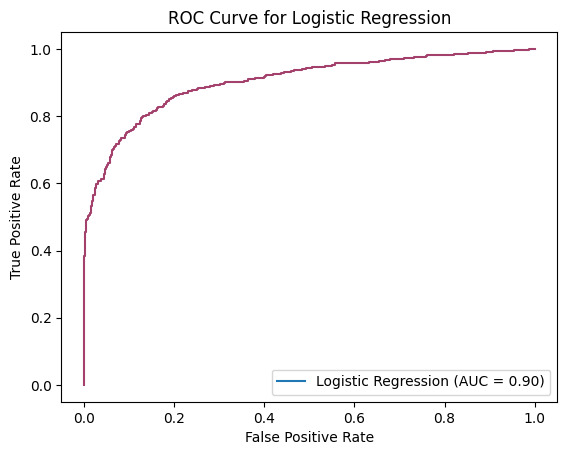

Test Set Accuracy: 0.8286666666666667


In [9]:
# Perform k-fold cross-validation on the validation set
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
validation_scores = cross_val_score(log_reg, X_valid_scaled, y_valid, cv=kfold, scoring='accuracy')

# Print cross-validation scores on the validation set
print("Validation Set Cross-Validation Scores:", validation_scores)

# Plot the ROC curve for the validation set
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
import matplotlib.pyplot as plt

y_pred_valid = log_reg.predict_proba(X_valid_scaled)[:, 1]
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, log_reg.predict_proba(X_valid_scaled)[:, 1])

# Display the ROC curve
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name='Logistic Regression')
display.plot()

# Customize the plot
ax = plt.gca()
ax.get_lines()[0].set_color('#a3416c')
plt.title('ROC Curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

test_accuracy = log_reg.score(X_valid_scaled, y_valid)
print("Test Set Accuracy:", test_accuracy)

In [10]:
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test_scaled)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[619 106]
 [146 629]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       725
           1       0.86      0.81      0.83       775

    accuracy                           0.83      1500
   macro avg       0.83      0.83      0.83      1500
weighted avg       0.83      0.83      0.83      1500



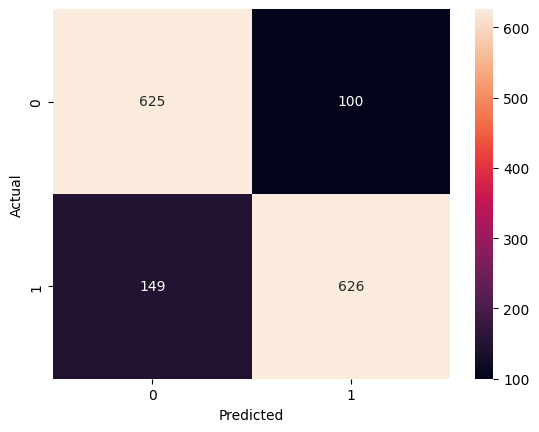

In [ ]:
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 3.3 Inferential Logistic Regression Model

In [12]:
import statsmodels.api as sm
import pandas as pd

# Separate features and target variable

df_log2 = df[["Age_at_Exam", "sBP", "BMI", "LDL", "A1c", "TG","Diabetes"]]
X = df_log2.drop(['Diabetes'], axis=1)
y = df_log2['Diabetes']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Impute with median
imputer = SimpleImputer(strategy='median')

imputer.fit(X[["sBP"]])
X["sBP"] = imputer.transform(X[['sBP']])

imputer.fit(X[["LDL"]])
X["LDL"] = imputer.transform(X[['LDL']])

imputer.fit(X[["TG"]])
X["TG"] = imputer.transform(X[['TG']])

# Create and fit logistic regression model
log_reg1 = sm.Logit(y, X).fit()

# Coefficients and their standard errors
coefficients = log_reg1.params
standard_errors = log_reg1.bse

# Calculate odds ratios
odds_ratios = np.exp(coefficients)

# Calculate 95% CI for odds ratios
lower_bound = np.exp(coefficients - 1.96 * standard_errors)
upper_bound = np.exp(coefficients + 1.96 * standard_errors)

# Print results
for idx, coef in enumerate(log_reg1.params.index):
    print(f"For {coef}: Odds Ratio: {odds_ratios[idx]:.4f}, 95% CI: ({lower_bound[idx]:.4f}, {upper_bound[idx]:.4f})")

# calculate specific OR for age difference of 10 years
odds_ratios = np.exp(10 * coefficients['Age_at_Exam'])  # Adjust for a 10-year difference

# Calculate 95% CI for odds ratios
lower_bound = np.exp(10 * (coefficients['Age_at_Exam'] - 1.96 * standard_errors['Age_at_Exam']))
upper_bound = np.exp(10 * (coefficients['Age_at_Exam'] + 1.96 * standard_errors['Age_at_Exam']))
print(f"For a 10-year difference in Age_at_Exam: Odds Ratio: {odds_ratios:.4f}, 95% CI: ({lower_bound:.4f}, {upper_bound:.4f})")

# Get summary report
summary = log_reg1.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.374640
         Iterations 8
For const: Odds Ratio: 0.0000, 95% CI: (0.0000, 0.0000)
For Age_at_Exam: Odds Ratio: 1.0039, 95% CI: (0.9991, 1.0087)
For sBP: Odds Ratio: 1.0016, 95% CI: (0.9981, 1.0050)
For BMI: Odds Ratio: 1.0261, 95% CI: (1.0172, 1.0351)
For LDL: Odds Ratio: 0.5553, 95% CI: (0.5200, 0.5930)
For A1c: Odds Ratio: 35.6382, 95% CI: (30.4770, 41.6734)
For TG: Odds Ratio: 1.1687, 95% CI: (1.1018, 1.2396)
For a 10-year difference in Age_at_Exam: Odds Ratio: 1.0397, 95% CI: (0.9914, 1.0905)
                           Logit Regression Results                           
Dep. Variable:               Diabetes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9993
Method:                           MLE   Df Model:                            6
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.4592
Time:                      